In [35]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.animation as animation

np.random.seed(1234)

In [36]:
# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

Using device: cuda
NVIDIA GeForce GTX 1650


In [37]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        modules = []
        for i in range(len(layers) - 2):  # Exclude last layer for activation
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))  # Last layer (no activation)
        self.network = nn.Sequential(*modules)

        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

In [66]:
lbfgs_lr = 0.005
adam_lr = 0.01

w_pde = 0.5
w_bc = 1.0
w_ic = 0.5

In [67]:
class PINN():
    def __init__(self, x, t, masks, layers, f, ic1, ic2):

        self.x = torch.tensor(x, dtype=torch.float, device=device, requires_grad=True).view(-1, 1)
        self.t = torch.tensor(t, dtype=torch.float, device=device, requires_grad=True).view(-1, 1)

        self.mask_d = masks["dom"]
        self.mask_lbc = masks["lbc"]
        self.mask_rbc = masks["rbc"]
        self.mask_ic = masks["ic"]

        self.f = torch.tensor(f, dtype=torch.float, device=device).view(-1, 1)
        self.ic1 = torch.tensor(ic1, dtype=torch.float, device=device).view(-1, 1)
        self.ic2 = torch.tensor(ic2, dtype=torch.float, device=device).view(-1, 1)

        # DNN
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=lbfgs_lr,
            max_iter=20000,
            max_eval=20000,
            history_size=200,
            tolerance_grad=1e-10,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=adam_lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer_adam, step_size=4000, gamma=0.5)
        self.iter = 0

    def model_value(self, x, t):
        u = self.dnn(torch.cat((x, t), dim=1))
        return u

    def loss_func(self, x, t):
        u = self.model_value(x, t)

        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
        u_2x = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
        u_3x = torch.autograd.grad(u_2x, x, torch.ones_like(u_2x), create_graph=True, retain_graph=True)[0]
        u_4x = torch.autograd.grad(u_3x, x, torch.ones_like(u_3x), create_graph=True)[0]

        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
        u_2t = torch.autograd.grad(u_t, t, torch.ones_like(u_t), create_graph=True)[0]      

        pde_loss = torch.mean(torch.pow((u_2t[self.mask_d] + u_4x[self.mask_d] - self.f), 2))

        bc_loss = torch.mean(torch.pow((u[self.mask_lbc]), 2))
        bc_loss += torch.mean(torch.pow((u_2x[self.mask_lbc]), 2))

        bc_loss = torch.mean(torch.pow((u[self.mask_rbc]), 2))
        bc_loss += torch.mean(torch.pow((u_2x[self.mask_rbc]), 2))

        ic_loss = torch.mean(torch.pow((u[self.mask_ic] - self.ic1), 2))
        ic_loss += torch.mean(torch.pow((u_t[self.mask_ic] - self.ic2), 2))

        return pde_loss, bc_loss, ic_loss

    def lbfgs_func(self):
        pde_loss, bc_loss, ic_loss = self.loss_func(self.x, self.t)
        loss = w_pde*pde_loss + w_bc*bc_loss + w_ic*ic_loss
        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
        self.iter += 1
        return loss
    
    def train(self, epochs=1000):
        self.dnn.train()
        for epoch in range(epochs):
            pde_loss, bc_loss, ic_loss = self.loss_func(self.x, self.t)
            loss = w_pde*pde_loss + w_bc*bc_loss + w_ic*ic_loss

            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()
            self.scheduler.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")
                print(f"PDE: {'{:e}'.format(pde_loss.item())}, BC: {'{:e}'.format(bc_loss.item())}, IC: {'{:e}'.format(ic_loss.item())}")
        self.optimizer_lbfgs.step(self.lbfgs_func)

    def predict(self, x, t):
        x = torch.tensor(x).float().to(device)
        t = torch.tensor(t).float().to(device)

        self.dnn.eval()
        u = self.model_value(x, t)
        u = u.detach().cpu().numpy()
        return u

In [68]:
def generate_points(points):
    n_d = points[0]
    n_bc = points[1]
    n_ic = points[2]

    x_d = np.random.rand(n_d) * np.pi
    t_d = np.random.rand(n_d)

    x_lbc = np.zeros(n_bc)
    t_lbc = np.random.rand(n_bc)

    x_rbc = np.ones(n_bc) * np.pi
    t_rbc = np.random.rand(n_bc)

    x_ic = np.random.rand(n_ic) * np.pi
    t_ic = np.zeros(n_ic)

    x_all = np.hstack((x_d, x_lbc, x_rbc, x_ic))
    t_all = np.hstack((t_d, t_lbc, t_rbc, t_ic))

    mask_lbc = np.equal(x_all, 0)
    mask_rbc = np.equal(x_all, np.pi)
    mask_ic = np.equal(t_all, 0)
    mask_d = ~(mask_lbc | mask_rbc | mask_ic)

    masks = {"lbc": mask_lbc, "rbc": mask_rbc, "ic": mask_ic, "dom": mask_d}

    return x_all, t_all, masks

In [69]:
p = [10000, 2000, 2000]
x, t, masks = generate_points(p)

In [70]:
mask_lbc = masks["lbc"]
mask_rbc = masks["rbc"]
mask_ic = masks["ic"]
mask_d = masks["dom"]

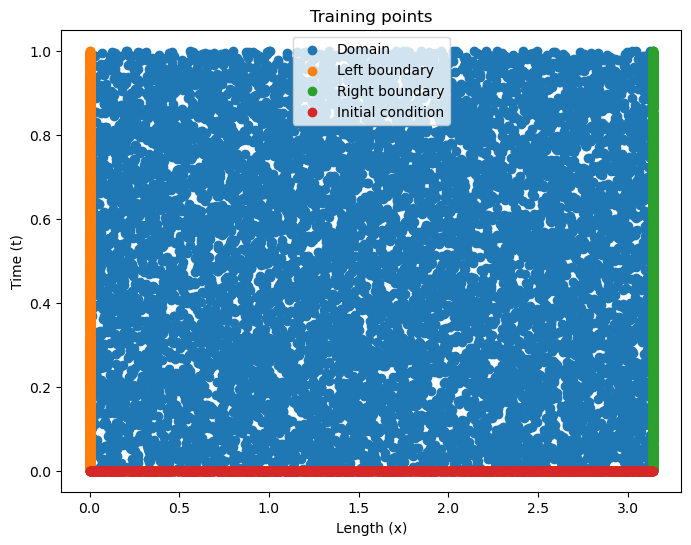

In [71]:
plt.figure(figsize=(8, 6))
plt.scatter(x[mask_d], t[mask_d], label="Domain")
plt.scatter(x[mask_lbc], t[mask_lbc], label="Left boundary")
plt.scatter(x[mask_rbc], t[mask_rbc], label="Right boundary")
plt.scatter(x[mask_ic], t[mask_ic], label="Initial condition")
plt.legend()
plt.title("Training points")
plt.xlabel("Length (x)")
plt.ylabel("Time (t)")
plt.show()

In [72]:
f = lambda x, t: (1 - 16*np.pi**2)*np.sin(x)*np.cos(4*np.pi*t)
ic1 = lambda x: np.sin(x)
ic2 = lambda x: np.full_like(x, 0)

vec1 = ic1(x[mask_ic])
vec2 = ic2(x[mask_ic])
fun = f(x[mask_d], t[mask_d])

In [73]:
print(fun.shape)

(10000,)


In [74]:
nodes = 64
layers = [2] + 5 * [nodes] + [1]

model = PINN(x, t, masks, layers, fun, vec1, vec2)

In [75]:
model.train(10000)

Epoch 0, Loss: 3.118866e+03
PDE: 6.236776e+03, BC: 6.693781e-02, IC: 8.225146e-01
Epoch 100, Loss: 1.068962e+02
PDE: 2.085565e+02, BC: 8.105614e-01, IC: 3.614742e+00
Epoch 200, Loss: 4.848816e+01
PDE: 9.557592e+01, BC: 2.950373e-01, IC: 8.103153e-01
Epoch 300, Loss: 1.999897e+01
PDE: 3.950754e+01, BC: 1.618461e-01, IC: 1.667169e-01
Epoch 400, Loss: 4.127433e+01
PDE: 8.146560e+01, BC: 1.201400e-01, IC: 8.427823e-01
Epoch 500, Loss: 7.346697e+00
PDE: 1.441514e+01, BC: 9.581285e-02, IC: 8.662828e-02
Epoch 600, Loss: 3.271911e+01
PDE: 6.449127e+01, BC: 7.269904e-02, IC: 8.015530e-01
Epoch 700, Loss: 8.700435e+00
PDE: 1.711258e+01, BC: 5.718246e-02, IC: 1.739231e-01
Epoch 800, Loss: 2.583886e+01
PDE: 5.135610e+01, BC: 5.522362e-02, IC: 2.111648e-01
Epoch 900, Loss: 1.521957e+01
PDE: 2.953610e+01, BC: 3.659572e-02, IC: 8.298412e-01
Epoch 1000, Loss: 4.054676e+00
PDE: 7.626399e+00, BC: 3.543248e-02, IC: 4.120877e-01
Epoch 1100, Loss: 7.099174e+00
PDE: 1.373939e+01, BC: 2.661699e-02, IC: 4.057

KeyboardInterrupt: 

In [76]:
torch.save(model.dnn.state_dict(), "time_model_test.pth")

In [61]:
# Load model
model = PINN(x, t, masks, layers, fun, vec1, vec2)
model.dnn.load_state_dict(torch.load("time_model_weights.pth", weights_only=True))

<All keys matched successfully>

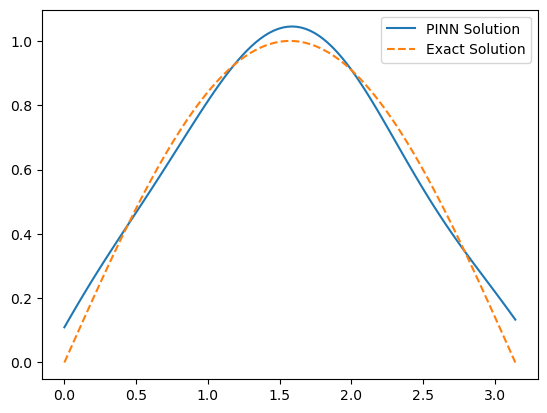

In [77]:

x = np.linspace(0, torch.pi, 100).reshape(-1, 1)
t = np.zeros(100).reshape(-1, 1)

y = np.sin(x)

u = model.predict(x, t)
plt.plot(x, u, label="PINN Solution")
plt.plot(x, y, label="Exact Solution", linestyle="dashed")
plt.legend()

In [78]:
# Define the resolution of the grid
x_min, x_max = 0, np.pi  # X range
t_min, t_max = 0, 1  # Time range
grid_size = 100  # Number of points in each dimension

# Create a meshgrid
x_vals = np.linspace(x_min, x_max, grid_size)
t_vals = np.linspace(t_min, t_max, grid_size)
X, T = np.meshgrid(x_vals, t_vals)  # Create a 2D meshgrid

# Flatten the meshgrid and convert to PyTorch tensor
X_flat = X.flatten().reshape(-1, 1)
T_flat = T.flatten().reshape(-1, 1)

u_exact = np.sin(X_flat) * np.cos(4 * torch.pi * T_flat)
u_pred = model.predict(X_flat, T_flat)

abs_error = np.abs(u_pred - u_exact)
l2_error = np.linalg.norm(u_pred - u_exact) / np.linalg.norm(u_exact, 2)

u_pred = u_pred.reshape(grid_size, grid_size)
u_exact = u_exact.reshape(grid_size, grid_size)
abs_error = abs_error.reshape(grid_size, grid_size)

print(l2_error)

0.15196029314447076


Animation saved as pde_solution.gif


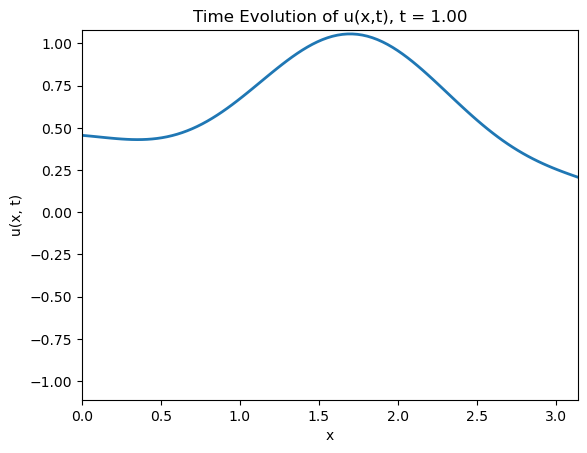

In [81]:
fig, ax = plt.subplots()

line, = ax.plot(x_vals, u_pred[0, :], lw=2)

ax.set_xlim(x_min, x_max)
ax.set_ylim(np.min(u_pred), np.max(u_pred))
ax.set_xlabel("x")
ax.set_ylabel("u(x, t)")
ax.set_title("Time Evolution of u(x, t)")

def update(frame):
    line.set_ydata(u_pred[frame, :])  # Update y-data for the line plot
    ax.set_title(f"Time Evolution of u(x,t), t = {t_vals[frame]:.2f}")
    return line,

ani = animation.FuncAnimation(fig, update, frames=grid_size, interval=50, blit=True)

# Save as a GIF
ani.save("pde_solution.gif", writer=animation.PillowWriter(fps=20))

print("Animation saved as pde_solution.gif")

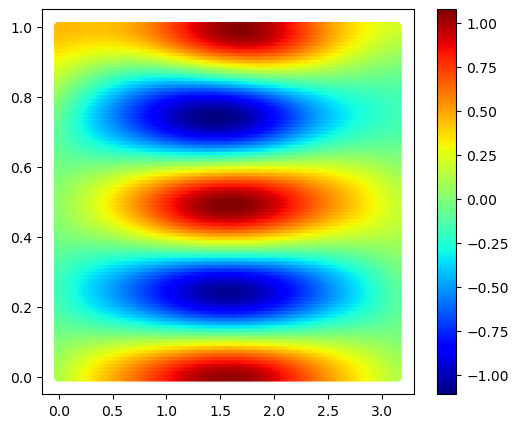

In [80]:
plt.figure(figsize=(6, 5))
sc = plt.scatter(X_flat, T_flat, c=u_pred, cmap='jet')
plt.colorbar(sc)
plt.show()

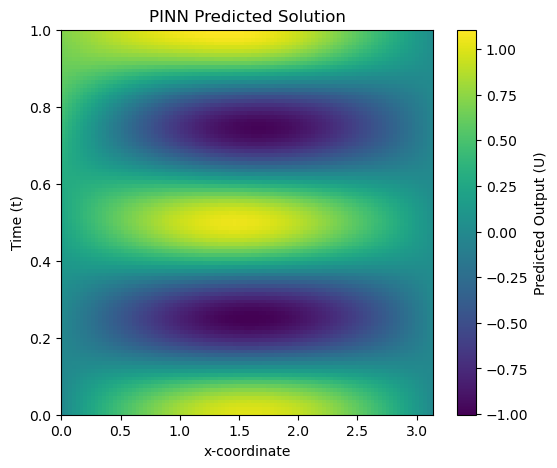

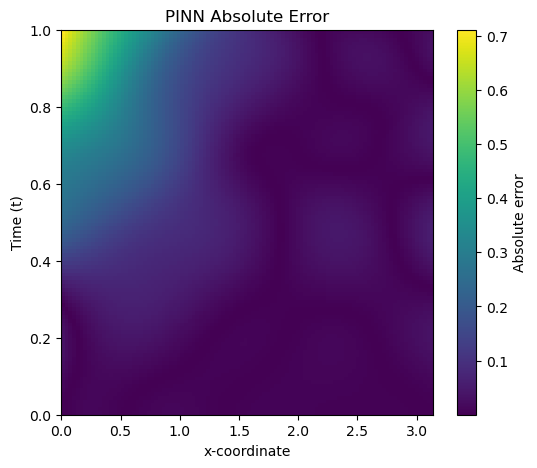

In [ ]:

plt.figure(figsize=(6, 5))
plt.imshow(u_pred, extent=[x_min, x_max, t_min, t_max], origin="lower", aspect="auto", cmap="jet")
plt.colorbar(label="Predicted Output (U)")
plt.xlabel("x-coordinate")
plt.ylabel("Time (t)")
plt.title("PINN Predicted Solution")


plt.figure(figsize=(6, 5))
plt.imshow(abs_error, extent=[x_min, x_max, t_min, t_max], origin="lower", aspect="auto", cmap="jet")
plt.colorbar(label="Absolute error")
plt.xlabel("x-coordinate")
plt.ylabel("Time (t)")
plt.title("PINN Absolute Error")

plt.show()